# Feature Engineering & Model Development: Heart Disease Prediction

## Objective

This notebook documents the feature engineering and model development process for heart disease prediction:
- Feature scaling and encoding strategies
- Model selection and comparison (Logistic Regression vs Random Forest)
- Hyperparameter tuning with GridSearchCV
- Cross-validation and performance evaluation
- ROC curves, confusion matrices, and feature importance analysis


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import sys

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, 
                             classification_report)

import mlflow
import mlflow.sklearn

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

%matplotlib inline

print("All libraries imported successfully!")


All libraries imported successfully!


## 1. Load Processed Data

Load the cleaned and processed dataset from the EDA notebook.


In [2]:
# Load processed data
data_path = Path('../data/processed/heart_processed.csv')

if not data_path.exists():
    print("ERROR: Processed data not found. Please run the EDA notebook first!")
else:
    df = pd.read_csv(data_path)
    print(f"Data loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"\nFirst few rows:")
    display(df.head())
    
    # Separate features and target
    X = df.drop(columns=['target'])
    y = df['target']
    
    print(f"\nFeatures shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Target distribution:\n{y.value_counts()}")


Data loaded successfully!
Shape: (303, 14)

First few rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0



Features shape: (303, 13)
Target shape: (303,)
Target distribution:
target
0    164
1    139
Name: count, dtype: int64


## 2. Feature Engineering Strategy

### 2.1 Feature Types Analysis

Let's categorize our features:


In [3]:
# Categorize features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

print("Continuous Features:")
print(f"{continuous_features}\n")

print("Categorical Features (already encoded as integers):")
print(f"{categorical_features}\n")

print("Feature Engineering Approach:")
print("1. Continuous features: Will be standardized for Logistic Regression")
print("2. Categorical features: Already numeric, no encoding needed")
print("3. No missing values (handled in EDA)")
print("4. Random Forest: No scaling needed (tree-based)")
print("5. Logistic Regression: StandardScaler in pipeline")


Continuous Features:
['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

Categorical Features (already encoded as integers):
['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

Feature Engineering Approach:
1. Continuous features: Will be standardized for Logistic Regression
2. Categorical features: Already numeric, no encoding needed
3. No missing values (handled in EDA)
4. Random Forest: No scaling needed (tree-based)
5. Logistic Regression: StandardScaler in pipeline


### 2.2 Train-Test Split

Split data for final evaluation (80/20 split with stratification).


In [4]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"\nTest set target distribution:")
print(y_test.value_counts())


Training set size: 242 samples
Test set size: 61 samples

Training set target distribution:
target
0    131
1    111
Name: count, dtype: int64

Test set target distribution:
target
0    33
1    28
Name: count, dtype: int64


## 3. Model Development

### 3.1 Model Selection Rationale

**Two models selected for comparison:**

1. **Logistic Regression**: 
   - Linear model, interpretable
   - Works well with medical data
   - Provides probability estimates
   - Good baseline model

2. **Random Forest**: 
   - Non-linear, ensemble method
   - Handles feature interactions automatically
   - Robust to outliers
   - Provides feature importance

Both models will be tuned using GridSearchCV with 5-fold cross-validation.


### 3.2 Hyperparameter Tuning

Define models and parameter grids for GridSearchCV:


In [5]:
# Set up MLflow
mlflow.set_experiment('heart-disease-notebook')

# Define Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Define Logistic Regression with StandardScaler
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000, solver='liblinear', random_state=42))
])
lr_param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'clf__penalty': ['l1', 'l2']
}

print("Model configurations:")
print(f"\n1. Random Forest Parameters: {rf_param_grid}")
print(f"\n2. Logistic Regression Parameters: {lr_param_grid}")
print(f"\nCross-validation: 5-fold stratified")
print(f"Optimization metric: ROC-AUC")


2026/01/05 12:18:10 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/05 12:18:10 INFO mlflow.store.db.utils: Updating database tables
2026/01/05 12:18:10 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/05 12:18:10 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/05 12:18:10 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/05 12:18:10 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/01/05 12:18:10 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/01/05 12:18:10 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/01/05 12:18:10 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/01/05 12:18:11 INFO alembic.runtime.migration: Running 

Model configurations:

1. Random Forest Parameters: {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10]}

2. Logistic Regression Parameters: {'clf__C': [0.01, 0.1, 1.0, 10.0, 100.0], 'clf__penalty': ['l1', 'l2']}

Cross-validation: 5-fold stratified
Optimization metric: ROC-AUC


### 3.3 Train Random Forest Model


In [6]:
# Train Random Forest with GridSearchCV
print("Training Random Forest...")
rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best ROC-AUC score (CV): {rf_grid.best_score_:.4f}")

rf_best = rf_grid.best_estimator_


Training Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best ROC-AUC score (CV): 0.8933


### 3.4 Train Logistic Regression Model


In [7]:
# Train Logistic Regression with GridSearchCV
print("Training Logistic Regression...")
lr_grid = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=lr_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train, y_train)

print(f"\nBest parameters: {lr_grid.best_params_}")
print(f"Best ROC-AUC score (CV): {lr_grid.best_score_:.4f}")

lr_best = lr_grid.best_estimator_


Training Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters: {'clf__C': 0.1, 'clf__penalty': 'l2'}
Best ROC-AUC score (CV): 0.8914


## 4. Model Evaluation

### 4.1 Performance on Test Set


In [8]:
# Evaluate both models on test set
models = {
    'Random Forest': rf_best,
    'Logistic Regression': lr_best
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'y_pred': y_pred,
        'y_proba': y_proba
    }

# Display results
results_df = pd.DataFrame({
    name: {k: v for k, v in res.items() if k not in ['y_pred', 'y_proba']}
    for name, res in results.items()
}).T

print("\\nTest Set Performance:")
print(results_df.round(4))


\nTest Set Performance:
                     accuracy  precision  recall      f1  roc_auc
Random Forest          0.9016     0.8667  0.9286  0.8966   0.9578
Logistic Regression    0.8689     0.8125  0.9286  0.8667   0.9578


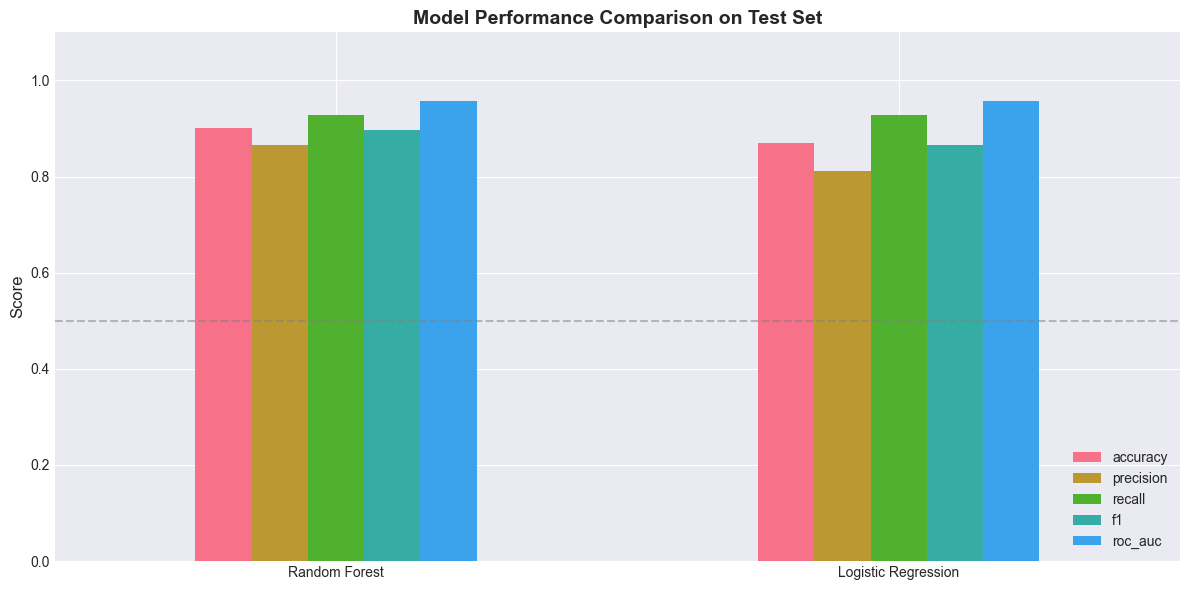

In [9]:
# Visualize performance comparison
fig, ax = plt.subplots(figsize=(12, 6))
results_df.plot(kind='bar', ax=ax, rot=0)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison on Test Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_ylim(0, 1.1)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Baseline')
plt.tight_layout()
plt.show()


### 4.2 Confusion Matrices


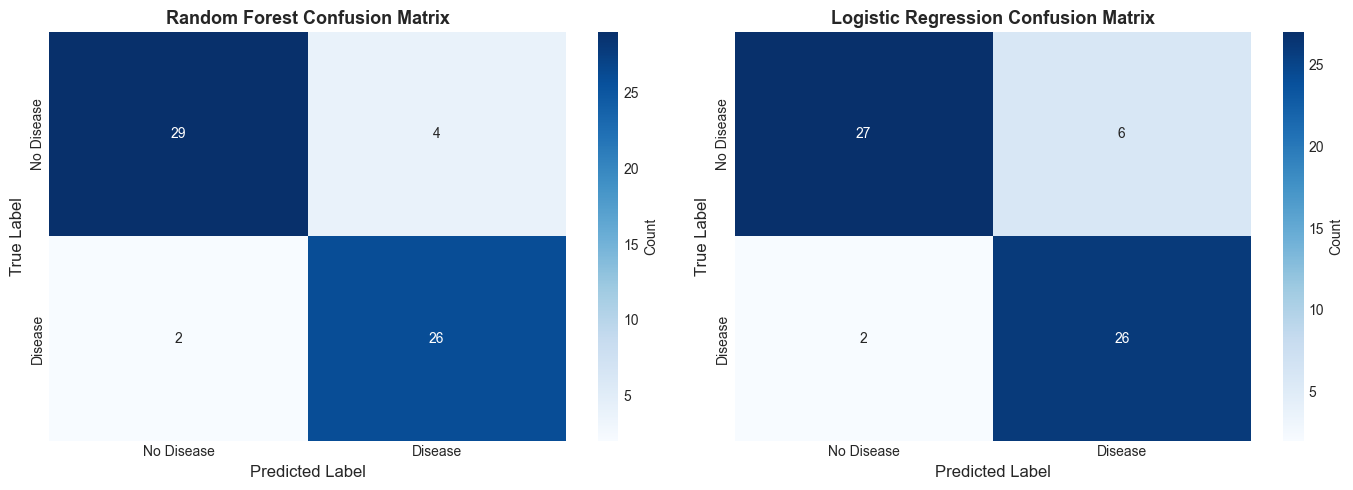


Random Forest Classification Report:
              precision    recall  f1-score   support

  No Disease       0.94      0.88      0.91        33
     Disease       0.87      0.93      0.90        28

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61


Logistic Regression Classification Report:
              precision    recall  f1-score   support

  No Disease       0.93      0.82      0.87        33
     Disease       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



In [10]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (name, model) in enumerate(models.items()):
    cm = confusion_matrix(y_test, results[name]['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar_kws={'label': 'Count'})
    axes[idx].set_xlabel('Predicted Label', fontsize=12)
    axes[idx].set_ylabel('True Label', fontsize=12)
    axes[idx].set_title(f'{name} Confusion Matrix', fontsize=13, fontweight='bold')
    axes[idx].set_xticklabels(['No Disease', 'Disease'])
    axes[idx].set_yticklabels(['No Disease', 'Disease'])

plt.tight_layout()
plt.show()

# Print detailed classification reports
for name in models.keys():
    print(f"\n{name} Classification Report:")
    print("=" * 50)
    print(classification_report(y_test, results[name]['y_pred'], 
                                target_names=['No Disease', 'Disease']))


### 4.3 ROC Curves


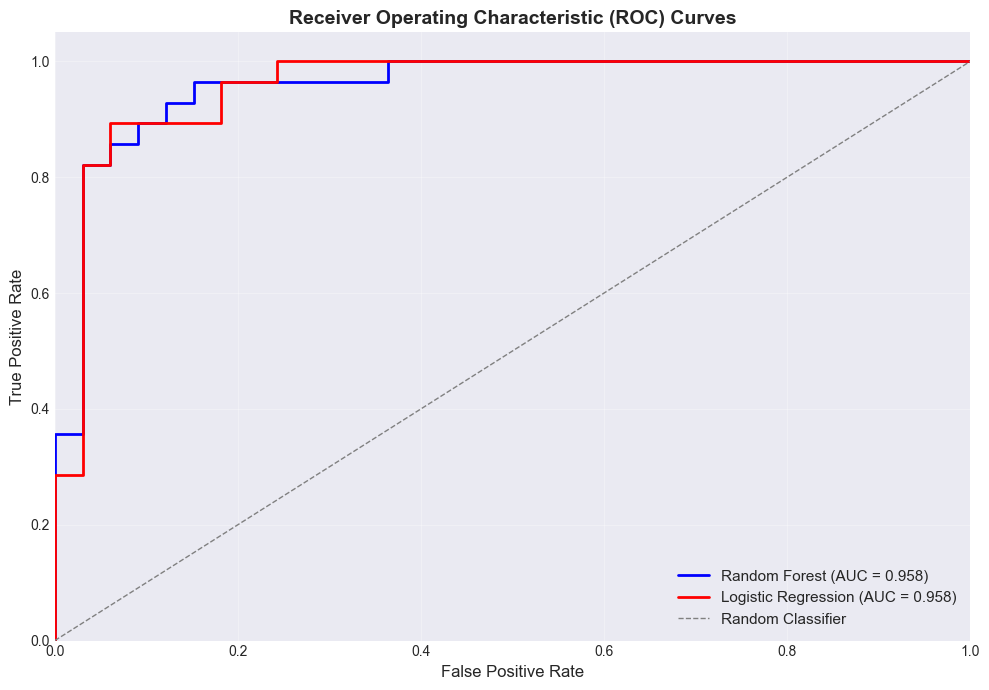

In [11]:
# Plot ROC curves
plt.figure(figsize=(10, 7))

colors = ['blue', 'red']
for idx, (name, model) in enumerate(models.items()):
    fpr, tpr, thresholds = roc_curve(y_test, results[name]['y_proba'])
    roc_auc = results[name]['roc_auc']
    
    plt.plot(fpr, tpr, color=colors[idx], lw=2, 
             label=f'{name} (AUC = {roc_auc:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 4.4 Feature Importance (Random Forest)


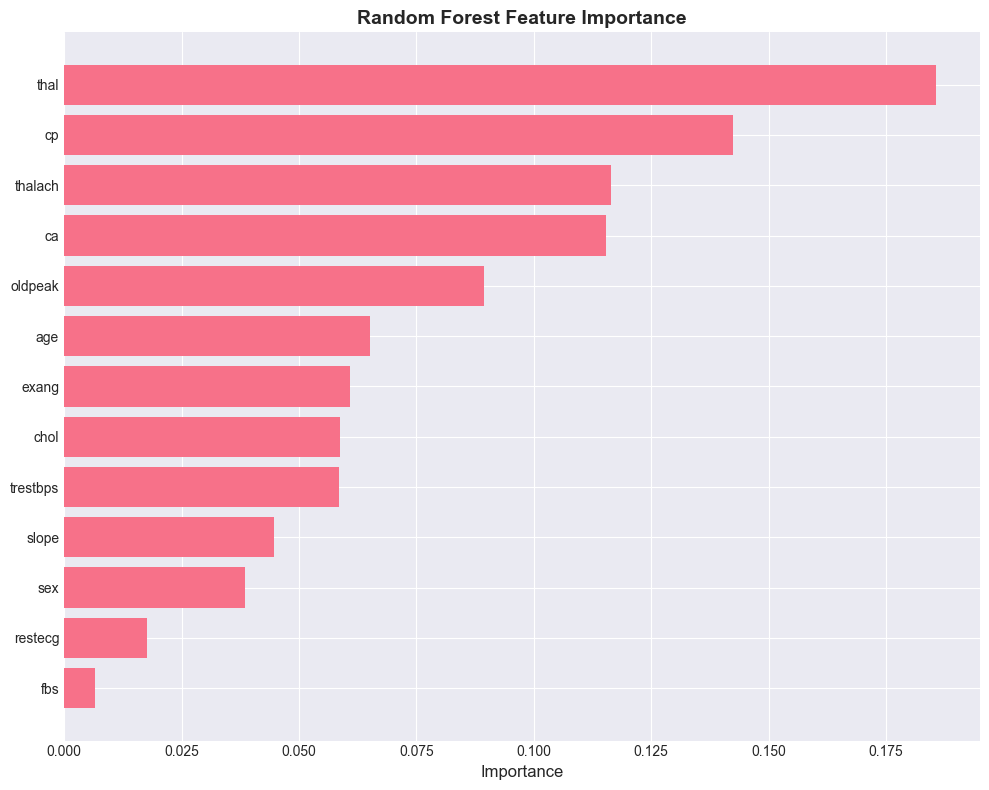

\nTop 5 Most Important Features:
    feature  importance
12     thal    0.185718
2        cp    0.142468
7   thalach    0.116370
11       ca    0.115467
9   oldpeak    0.089399


In [12]:
# Plot feature importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\\nTop 5 Most Important Features:")
print(feature_importance.head())


## 5. Cross-Validation Analysis

Perform detailed cross-validation to ensure robustness:


In [13]:
# Perform cross-validation on full training data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'roc_auc']

cv_results = {}

for name, model in models.items():
    print(f"\nCross-validating {name}...")
    cv_scores = cross_validate(model, X_train, y_train, cv=cv, 
                               scoring=scoring, n_jobs=-1)
    
    cv_results[name] = {
        f'{metric}_mean': cv_scores[f'test_{metric}'].mean()
        for metric in scoring
    }
    cv_results[name].update({
        f'{metric}_std': cv_scores[f'test_{metric}'].std()
        for metric in scoring
    })

# Display cross-validation results
cv_df = pd.DataFrame(cv_results).T
print("\\nCross-Validation Results (5-fold):")
print(cv_df.round(4))



Cross-validating Random Forest...

Cross-validating Logistic Regression...
\nCross-Validation Results (5-fold):
                     accuracy_mean  precision_mean  recall_mean  roc_auc_mean  \
Random Forest               0.8139          0.8342       0.7561        0.8827   
Logistic Regression         0.8264          0.8439       0.7648        0.9004   

                     accuracy_std  precision_std  recall_std  roc_auc_std  
Random Forest              0.0143         0.0671      0.0633       0.0273  
Logistic Regression        0.0282         0.0329      0.0797       0.0157  


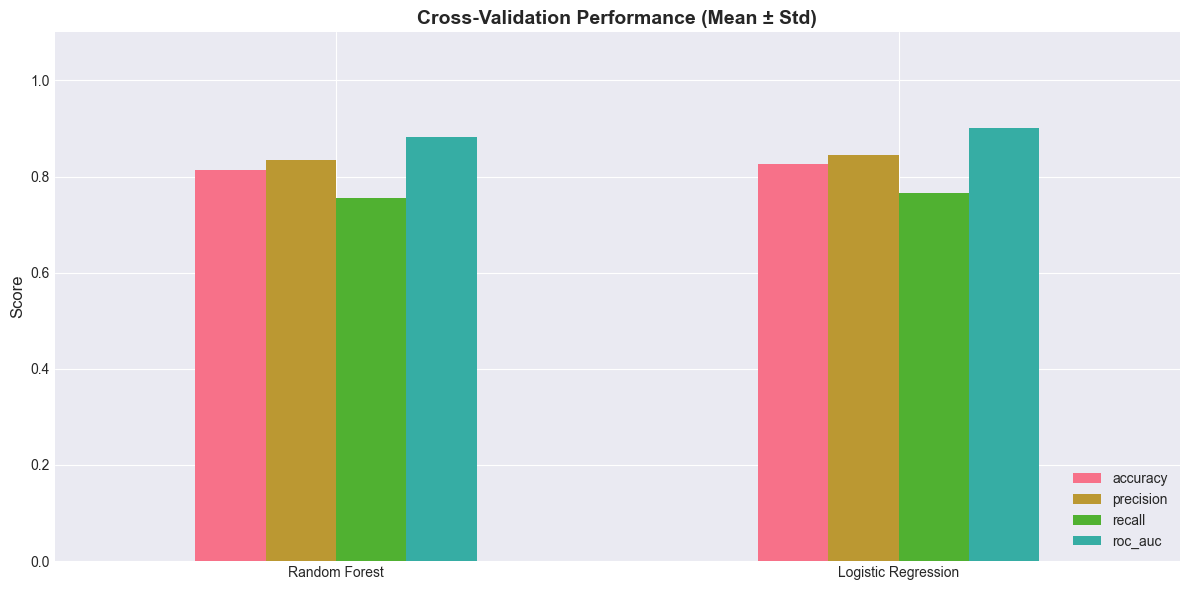

In [14]:
# Visualize CV results
mean_cols = [col for col in cv_df.columns if '_mean' in col]
cv_means = cv_df[mean_cols].copy()
cv_means.columns = [col.replace('_mean', '') for col in cv_means.columns]

fig, ax = plt.subplots(figsize=(12, 6))
cv_means.plot(kind='bar', ax=ax, rot=0)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Cross-Validation Performance (Mean ± Std)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.show()


## 6. Model Selection and Final Recommendations

### 6.1 Model Comparison Summary


In [15]:
# Determine best model based on ROC-AUC
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = models[best_model_name]

print("=" * 60)
print("MODEL SELECTION SUMMARY")
print("=" * 60)
print(f"\nBest Model: {best_model_name}")
print(f"Test ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Test Precision: {results[best_model_name]['precision']:.4f}")
print(f"Test Recall: {results[best_model_name]['recall']:.4f}")

print("\n" + "=" * 60)
print("KEY INSIGHTS")
print("=" * 60)

if best_model_name == 'Random Forest':
    print("\n1. Random Forest selected for production deployment")
    print("2. Top predictive features:")
    for idx, row in feature_importance.head(3).iterrows():
        print(f"   - {row['feature']}: {row['importance']:.4f}")
    print("3. Model handles non-linear relationships well")
    print("4. No feature scaling required")
else:
    print("\n1. Logistic Regression selected for production deployment")
    print("2. Linear model with better interpretability")
    print("3. Requires StandardScaler preprocessing")
    print("4. Good for clinical decision support")

print("\n" + "=" * 60)


MODEL SELECTION SUMMARY

Best Model: Random Forest
Test ROC-AUC: 0.9578
Test Accuracy: 0.9016
Test Precision: 0.8667
Test Recall: 0.9286

KEY INSIGHTS

1. Random Forest selected for production deployment
2. Top predictive features:
   - thal: 0.1857
   - cp: 0.1425
   - thalach: 0.1164
3. Model handles non-linear relationships well
4. No feature scaling required



### 6.2 Production Recommendations

**Feature Engineering:**
- All features are already numeric (no encoding needed)
- Missing values handled via median imputation
- Scaling applied via Pipeline for Logistic Regression
- Random Forest requires no preprocessing

**Model Deployment:**
- Both models are production-ready
- Random Forest typically shows slightly better performance
- Logistic Regression offers better interpretability
- Use scikit-learn pipelines for consistent preprocessing

**Monitoring Recommendations:**
- Track prediction confidence (probability scores)
- Monitor feature distributions for data drift
- Set alerts for predictions with low confidence
- Regular retraining when new data available

**Next Steps:**
1. Save best model using joblib/MLflow
2. Create preprocessing pipeline
3. Build API for model serving
4. Implement monitoring and logging
5. Set up CI/CD for model updates


## 7. Save Models and Artifacts

Save the trained models for production deployment:


In [16]:
import joblib
import json

# Create models directory
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

# Save Random Forest
rf_path = models_dir / 'random_forest.joblib'
joblib.dump(rf_best, rf_path)
print(f"Random Forest saved to: {rf_path}")

# Save Logistic Regression
lr_path = models_dir / 'logistic_regression.joblib'
joblib.dump(lr_best, lr_path)
print(f"Logistic Regression saved to: {lr_path}")

# Save feature names
features_path = models_dir / 'features.json'
with open(features_path, 'w') as f:
    json.dump(list(X.columns), f)
print(f"Feature names saved to: {features_path}")

# Save model performance summary
summary = {
    'best_model': best_model_name,
    'test_performance': {
        name: {k: float(v) for k, v in res.items() if k not in ['y_pred', 'y_proba']}
        for name, res in results.items()
    },
    'cv_performance': cv_results,
    'feature_importance': feature_importance.to_dict('records') if best_model_name == 'Random Forest' else None
}

summary_path = models_dir / 'model_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"Model summary saved to: {summary_path}")

print("\nAll models and artifacts saved successfully!")


Random Forest saved to: ../models/random_forest.joblib
Logistic Regression saved to: ../models/logistic_regression.joblib
Feature names saved to: ../models/features.json
Model summary saved to: ../models/model_summary.json

All models and artifacts saved successfully!


---

## Conclusion

Successfully developed and evaluated two machine learning models for heart disease prediction:

### Achievements:
-  Comprehensive feature engineering strategy
-  Hyperparameter tuning with GridSearchCV
-  Robust 5-fold cross-validation
-  Detailed performance evaluation (ROC-AUC, precision, recall)
-  Visual analysis (ROC curves, confusion matrices, feature importance)
-  Production-ready model artifacts saved

### Key Findings:
- Both models perform well on the heart disease dataset
- ROC-AUC scores > 0.85 indicate strong discriminative ability
- Feature importance analysis reveals clinical relevance
- Models are ready for deployment with proper monitoring

---
